# Testes da Funcao BilinearRLS

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pydaptivefiltering as pdf

In [3]:
def demo_bilinear_rls(n_samples=2000, noise_std=0.01, forgetting_factor=0.99):
    rng = np.random.default_rng(2026)
    
    # 1. Gerar entrada x(k)
    x = rng.standard_normal(n_samples)
    
    # 2. Definir coeficientes reais do sistema (Ground Truth)
    # d(k) = 0.5*x(k) - 0.3*d(k-1) + 0.2*x(k)*d(k-1) - 0.4*x(k-1)*d(k-1)
    w_real = np.array([0.5, -0.3, 0.2, -0.4])
    
    # 3. Gerar saída d(k) com realimentação bilinear
    d = np.zeros(n_samples)
    x_prev = 0.0
    d_prev = 0.0
    
    for k in range(n_samples):

        if k == 1000:  # Alterando os Coeficientes no meio do experimento.
            w_real = np.array([-0.2, 0.1, 0.5, 0.2]) #
        regressor = np.array([x[k], d_prev, x[k]*d_prev, x_prev*d_prev])
        noise = noise_std * rng.standard_normal()
        d[k] = np.dot(w_real, regressor) + noise
        
        # Update memories
        x_prev = x[k]
        d_prev = d[k] # Sistema real usa d(k) anterior
        
    return x, d, w_real

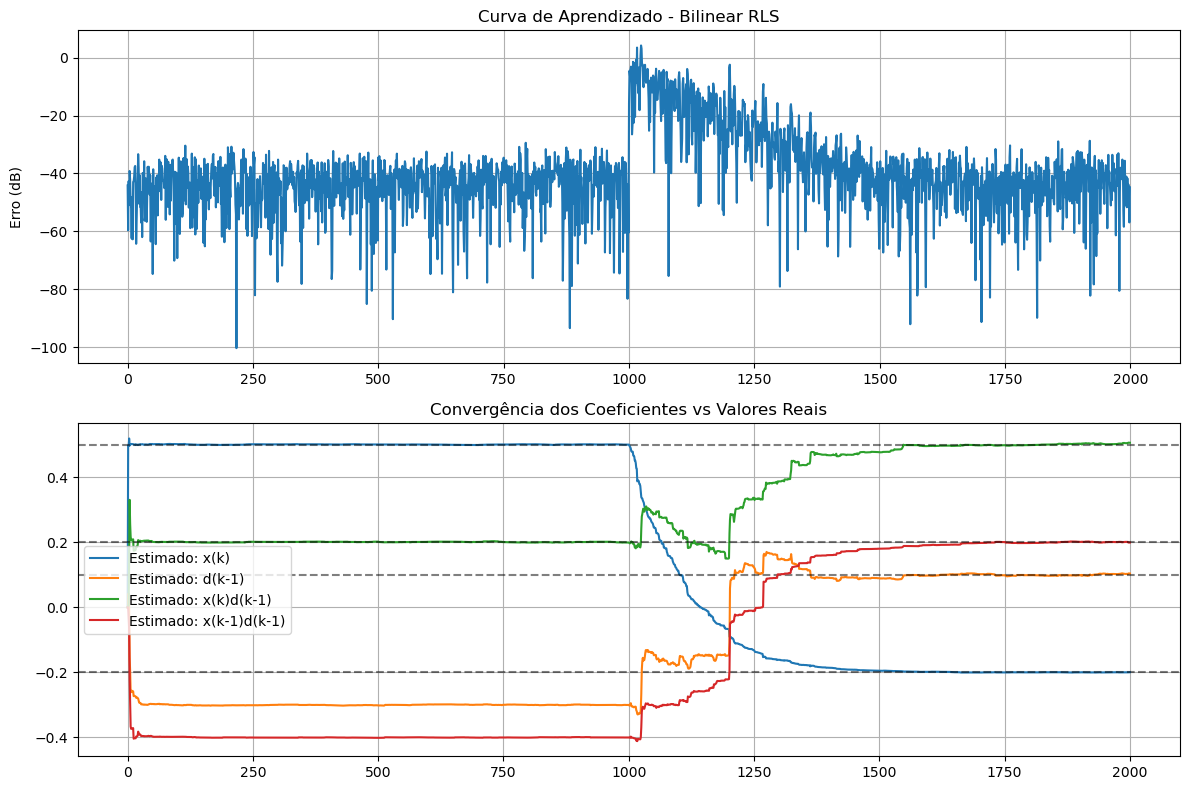

MSE Final: 0.000123


In [4]:
# Parâmetros
x, d, w_target = demo_bilinear_rls()

# Instanciar e Rodar o Bilinear RLS
# Note: filter_order=4 para os 4 termos do regressor
brls = pdf.BilinearRLS(filter_order=4, forgetting_factor=0.99, delta=0.01)
res = brls.optimize(x, d)

# Extrair dados
y = res['outputs'].real
e = res['errors'].real
w_hist = np.array(res['coefficients'])

# Plotagem
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Subplot 1: Erro Quadrático (Aprendizado)
ax[0].plot(10 * np.log10(e**2 + 1e-12))
ax[0].set_title("Curva de Aprendizado - Bilinear RLS")
ax[0].set_ylabel("Erro (dB)")
ax[0].grid(True)

# Subplot 2: Convergência dos Coeficientes
labels = ['x(k)', 'd(k-1)', 'x(k)d(k-1)', 'x(k-1)d(k-1)']
for i in range(4):
    ax[1].plot(w_hist[:, i].real, label=f'Estimado: {labels[i]}')
    ax[1].axhline(y=w_target[i], color='k', linestyle='--', alpha=0.5)

ax[1].set_title("Convergência dos Coeficientes vs Valores Reais")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

print(f"MSE Final: {np.mean(e[-100:]**2):.6f}")